In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
import radical.entk as re

In [2]:
! radical-stack


  python               : 3.7.6
  pythonpath           : 
  virtualenv           : base

  radical.analytics    : 0.90.7
  radical.entk         : 1.4.0
  radical.pilot        : 1.4.1
  radical.saga         : 1.4.0
  radical.utils        : 1.4.0



In [3]:
suds = ['re.session.login1.litan.018465.0002']
sdir = '../data/raw/'
sids = [sdir+s for s in suds]

In [4]:
ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

session loaded
session loaded
session loaded
session loaded
session loaded


In [5]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [6]:
for sid in suds:
    print("""
%s:
\tName of the HPC platform: %s
\tPilot launch method: %s
\tNumber of pilots requested: %i
\tNumber of pilots active: %i
\tNumber of requested cores: %i
\tNumber of requested GPUs: %s
\tNumber of requested nodes: %s
\tNumber of nodes asked by ENTK: %i
\tNumber of tasks executed by EnTK: %i
\tNumber of tasks successfully executed by EnTK: %i
\tNumber of failed tasks: %i
""" % (sid              , ss[sid]['pres']  , ss[sid]['lm'], 
       ss[sid]['npilot'], ss[sid]['npact'] , ss[sid]['ncores']/4, 
       ss[sid]['ngpus'] , ss[sid]['nnodes'], ss[sid]['ncores']/168, 
       ss[sid]['nunit'] , ss[sid]['nudone'], ss[sid]['nufail']))


re.session.login1.litan.018465.0002:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 21504
	Number of requested GPUs: 3072
	Number of requested nodes: 512.0
	Number of nodes asked by ENTK: 512
	Number of tasks executed by EnTK: 1050
	Number of tasks successfully executed by EnTK: 991
	Number of failed tasks: 59



In [7]:
for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttc'  : p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]]),
      'ttq_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_w': w.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.DONE        } ]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]]),
      'sub_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  } ]),
      'ttx_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  },
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_w'] - ss[sid]['ttx_u']})

/root/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


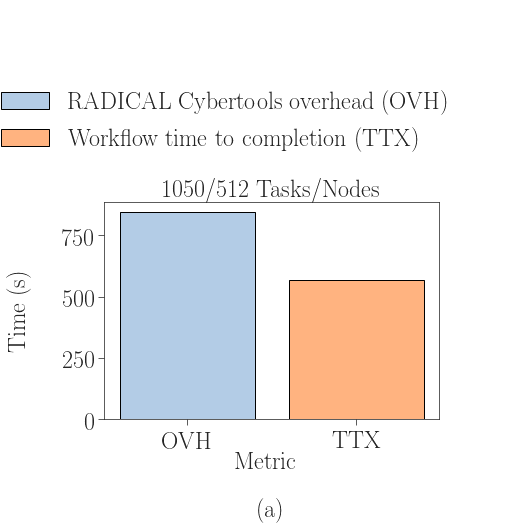

In [8]:
fwidth = 6*len(suds)
fhight = 4
fig, axarr = plt.subplots(1, len(suds), sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_u']  , color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)

    i = i+1
    j = chr(ord(j) + 1)

fig.text(-0.1,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text( 0.5, -0.05, 'Metric'  , ha='center', fontsize=24)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.6), fontsize=24, ncol=1)
    
plt.savefig('figures/incite2020_ovh_ttx_jsrun4.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite2020_ovh_ttx_jsrun4.png', dpi=300, bbox_inches='tight')

In [ ]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [ ]:
sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

In [ ]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

In [ ]:
def update_ticks(x, pos):
    return int(x/4)

In [ ]:
# core/gpu utilization over time (box plot)

fwidth = 10*len(suds)
fhight = 4
fig, axarr = plt.subplots(1, len(suds), sharex='col', figsize=(fwidth, fhight))  # , sharey='row')

i = 0
j = 'a'
for sid in suds:

    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0,  0.5, 'Core ID' , va='center', rotation='vertical', fontsize=24)
fig.text( 0.5 , -0.1, 'Time (s)', ha='center', fontsize=24)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics_default], loc='upper center', 
           bbox_to_anchor=(0.7, 1.7), fontsize=26, ncol=4)

plt.savefig('figures/incite2020_inversions_jsrun.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite2020_inversions_jsrun.png', dpi=300, bbox_inches='tight')

In [ ]:
for sid in suds:
    print(info[sid])

In [ ]:
# Ordered list of events for a unit. Used to rapid visual debug. Can be exported in csv.
# for unit in u.filter(etype='unit', uid='unit.000000').timestamps():
#     print(", ".join(map(str, unit)))

In [ ]:

u_load    = [{ru.EVENT: 'state'        , ru.STATE: rp.NEW }, 
             {ru.EVENT: 'cu_exec_start', ru.STATE: None   }]

u_execute = [{ru.EVENT: 'cu_exec_start', ru.STATE: None   },      
             {ru.EVENT: 'cu_exec_stop' , ru.STATE: None   }]

u_unload  = [{ru.EVENT: 'cu_exec_stop' , ru.STATE: None   }, 
             {ru.EVENT: 'state'        , ru.STATE: rp.DONE}]

In [ ]:
u_durations = {}
for uid in ss['re.session.login3.litan.018427.0010']['u'].list('uid'):
    unit = ss['re.session.login3.litan.018427.0010']['u'].get(etype='unit', uid=uid)[0]
    load = unit.duration(event=u_load)
    execute = unit.duration(event=u_execute)
    unload = unit.duration(event=u_unload)
    u_durations[uid] = {'load': load, 'execute': execute, 'unload': unload}

In [ ]:
u_durations_df = pd.DataFrame.from_dict(u_durations, orient='index')
u_durations_df

In [ ]:
fig, ax  = fig_setup(figsize=(6,6))

box = plt.boxplot([u_durations_df['load'].values, u_durations_df['unload'].values], patch_artist=True)

colors = ['lightgreen', 'red']
for patch, color in zip(box['boxes'], colors):
    patch.set(facecolor=color)       

    
plt.legend(loc='upper right', bbox_to_anchor=(1.7,1), labels=['1: load', '2: unload'])
plt.xlabel('durations')
plt.ylabel('time (s)')

# plt.savefig('figures/paper_titan_rp_profiler_overhead.pdf', dpi=300, bbox_inches='tight')